# Natural Language Processing with Amazon Reviews

Developed for the second project of the Artificial Intelligence course

## Setup and Environment

After installing Python and the necessary packages, run the following code to import them:

In [1]:
%matplotlib inline

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sb
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import *
import nltk

[nltk_data] Downloading package stopwords to /home/bruno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Implementation work

### Loading the data

In [46]:
train = pd.read_csv('./data/train.csv', dtype={
    'class_index': int, 'review_title': str, 'review_text': str
}).groupby('class_index').apply(lambda x: x.sample(2000))  # Sample data with all classes uniformly

test = pd.read_csv('./data/test.csv', dtype={
    'class_index': int, 'review_title': str, 'review_text': str
}).groupby('class_index').apply(lambda x: x.sample(400))  # Sample data with all classes uniformly

train.head()


class_index                   review_title  \
class_index                                                       
1           1121379            1                 Wasted Efforts   
            946978             1        Bad! Don't buy this dvd   
            1239418            1  good coffee, bad coffee maker   
            1611293            1                 Savage indeed.   
            1240316            1    Does not work with Win2K OS   

                                                           review_text  
class_index                                                             
1           1121379  Most of the songs on this album are lifeless, ...  
            946978   Wow, this is a really terrible dvd. The filmin...  
            1239418  Too bad the coffee maker died after about 12 m...  
            1611293  The blueprint on mental disorders where the "s...  
            1240316  It does not work with Windows 2000 and it asks...

### Searching for null values

In [10]:
print("Columns with empty review text", len(train.loc[train['review_text'] == ""]))
print("Columns with missing review text", len(train.loc[train['review_text'] == None]))

print("Columns with empty review title", len(train.loc[train['review_title'] == ""]))
print("Columns with missing review title", len(train.loc[train['review_title'] == None]))

print("Columns with empty class index", len(train.loc[train['class_index'] == ""]))
print("Columns with missing class index", len(train.loc[train['class_index'] == None]))

Columns with empty review text 0
Columns with missing review text 0
Columns with empty review title 0
Columns with missing review title 0
Columns with empty class index 0
Columns with missing class index 0


As we can see, the dataset does not contain any empty or missing values

### Studying the data

<AxesSubplot:>

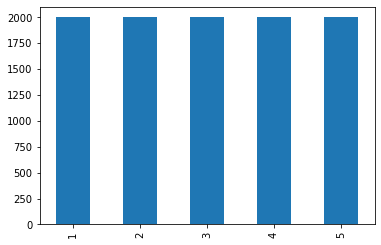

In [13]:
train['class_index'].value_counts().plot(kind='bar')

As the dataset creators have told us, the training dataset consists of 600 thousand rows for each review score, from 1 to 5. Since we've sampled it to 10 thousand samples evenly, we have 2 thousand rows for each review score.

##### Most frequent Words

/home/bruno/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 0, 'Words'), Text(0, 0.5, 'Occurrencies')]

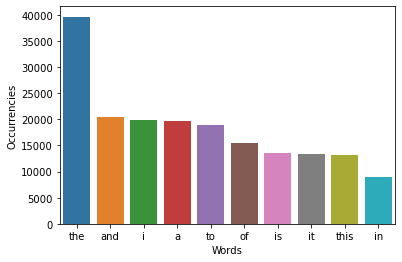

In [14]:
from collections import Counter

mostUsed = pd.Series(' '.join(train['review_text']).lower().split()).value_counts()[:10]
mostUsedGraph = sb.barplot(mostUsed.index, mostUsed.values)
mostUsedGraph.set(xlabel="Words", ylabel="Occurrencies")

### Treating the data
##### Cleanup and Normalization

In [48]:
ps = PorterStemmer()
# It's important to keep negative words in the sa
customStopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "should", "now"]

def normalize(text):
    # remove non alpha chars
    text = re.sub('[^a-zA-Z0-9]', ' ', str(text))
    # to lower-case and tokenize
    text = text.lower().split()
    # stemming and stop word removal
    text = ' '.join([ps.stem(w) for w in text if not w in customStopwords])

    return text

train['review_text'] = train['review_text'].apply(normalize)

train['review_title'] = train['review_title'].apply(normalize)
train.head()


test['review_text'] = test['review_text'].apply(normalize)
test['review_title'] = test['review_title'].apply(normalize)

##### Saving Preprocessed data
Since the original dataset is very large, we can sample it and save the preprocessed data in a different csv file, so it can be used later.

In [49]:
def savePreprocessedData(dataSet, fileName):
    dataSet.to_csv(fileName, index=False)

savePreprocessedData(train, './data/train_preprocessed.csv')
savePreprocessedData(test, './data/test_preprocessed.csv')

##### Generating wordclouds
A visually appealing way of observing words in a dataset is by showing wordclouds. In order to make a single wordcloud for a whole column, we can join all the cells together. We then pass it to WordCloud to generate a wordcloud: it will automatically assign weights to words based on the number of occurrences of each word.

These are the most common words in the reviews' titles:

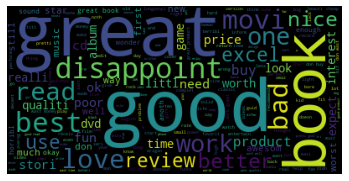

In [50]:
wordcloudTitle = WordCloud().generate(" ".join([str(x) for x in train['review_title'].values]))

plt.figure()
plt.imshow(wordcloudTitle)
plt.axis('off')
plt.show()

These are the most common words in the reviews' text:

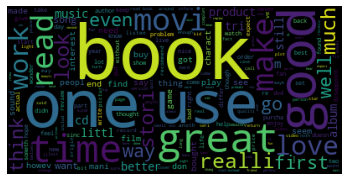

In [51]:
wordcloudText = WordCloud().generate(" ".join([str(x) for x in train['review_text'].values]))

plt.figure()
plt.imshow(wordcloudText)
plt.axis('off')
plt.show()

It would also be interesting to visualize a wordcloud for each of the reviews' classes (1 to 5):

Word cloud for class 1's titles:


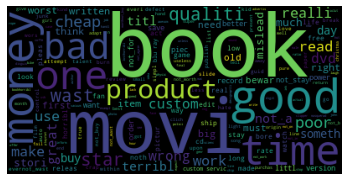

Word cloud for class 1's text:


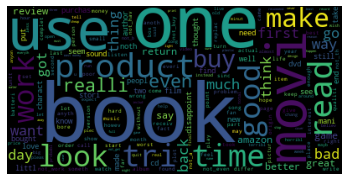

Word cloud for class 2's titles:


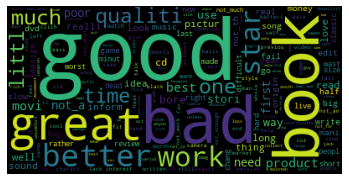

Word cloud for class 2's text:


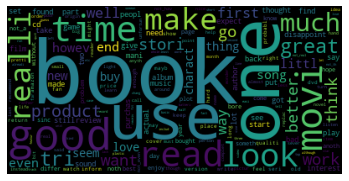

Word cloud for class 3's titles:


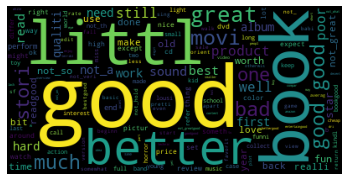

Word cloud for class 3's text:


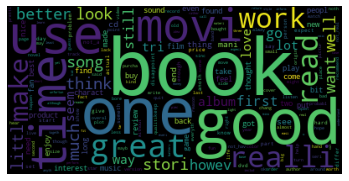

Word cloud for class 4's titles:


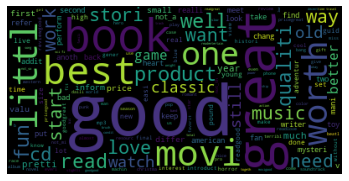

Word cloud for class 4's text:


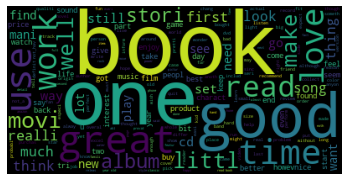

Word cloud for class 5's titles:


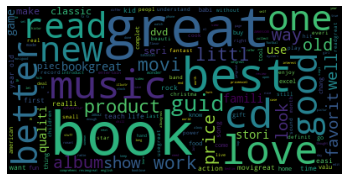

Word cloud for class 5's text:


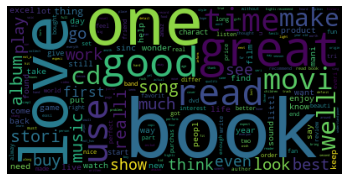

In [41]:
wordsPerClass = {
    1: ("", ""), # title and text
    2: ("", ""),
    3: ("", ""),
    4: ("", ""),
    5: ("", ""),
}

for i in range(len(train)):
    classId = int(train['class_index'].values[i])
    titleWords = train['review_title'].values[i]
    textWords = train['review_text'].values[i]
    
    wordsPerClass[classId] = (wordsPerClass[classId][0] + titleWords, wordsPerClass[classId][1] + textWords)

for i in range(1, 6):
    # Word cloud for class's titles
    wordcloudTitle = WordCloud().generate(wordsPerClass[i][0])
    print(f"Word cloud for class {i}'s titles:")

    plt.figure()
    plt.imshow(wordcloudTitle)
    plt.axis('off')
    plt.show()

    # Word cloud for class's text
    wordcloudText = WordCloud().generate(wordsPerClass[i][1])
    print(f"Word cloud for class {i}'s text:")

    plt.figure()
    plt.imshow(wordcloudText)
    plt.axis('off')
    plt.show()

### Generating a data set
#### Obtaining features from the Bag-of-Words model

In [52]:
train = pd.read_csv('./data/train_preprocessed.csv')
test = pd.read_csv('./data/test_preprocessed.csv')

vectorizer = CountVectorizer()

trainArr = map(str, train['review_title'])

titleWords = vectorizer.fit_transform(trainArr).toarray()

print(titleWords.shape)
print(vectorizer.get_feature_names())

(10000, 6343)
['00', '000', '04', '05', '06', '0m9', '0wn5', '10', '100', '1000', '101', '10bux', '10mp', '10th', '11', '1100', '12', '1200', '1200w', '1220u', '128ld', '13', '14', '14k', '15', '150', '16', '160', '1600dcd', '16x', '17', '18', '1800', '1850', '1860', '1866', '19', '1930', '1950', '1951', '1952', '1960', '1961', '1966', '1967', '1969', '1970', '1980', '1982', '1988', '1990', '1994', '1997', '1998', '1999', '1of', '1s', '1st', '20', '200', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '21', '2100', '21st', '22', '24', '25', '26', '2600', '280', '29', '296', '2ish', '2nd', '2oldfart', '30', '300', '300m', '300w', '305', '30gb', '31', '3100', '3300', '35', '36', '360', '37', '38826', '3and1', '3d', '3m', '3mp', '3rd', '40', '42', '46', '46f', '48315', '4870gz', '4g', '4pro', '4real', '4th', '4x', '50', '500', '50mm', '50ul', '5100', '512mb', '514', '530tx', '54gl', '590', '5mm', '5th', '60', '600', '61', '65', '650', '6707e', '6th'

/home/bruno/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Obtaining the Test classes

In [53]:
y = train['class_index']

# print(X.shape, y.shape)

### Training Classifiers

In [54]:
clf = MultinomialNB()
clf.fit(titleWords, y)

testArr = map(str, test['review_title'])
testVector = vectorizer.transform(testArr).toarray()

y_pred = clf.predict(testVector)
print(y_pred)

[1 5 1 ... 5 5 5]


### Analyse Results

In [55]:
# confusion matrix
confusionMatrix = confusion_matrix(test['class_index'], y_pred)
print(confusionMatrix)

correctReviews = 0
for i in range(len(confusionMatrix)):
    correctReviews += confusionMatrix[i][i]

incorrectReviews = sum(map(sum, confusionMatrix)) - correctReviews
# print("correctReviews:", correctReviews)
# print("incorrectReviews:", incorrectReviews)

accuracy = (correctReviews / (incorrectReviews + correctReviews)) * 100

# accuracy, precision, recall, f1
# CHECK IF CONFUSION MATRIX IS ORDER FROM 1-5 RATING
print("Accuracy:", accuracy)
for i in range(5):
    colSum = 0
    for j in range(5):
        colSum += confusionMatrix[j][i]
    
    precision = (confusionMatrix[i][i] / colSum)
    recall = (confusionMatrix[i][i] / sum(confusionMatrix[i]))
    fMeasure = (2*precision*recall) / (precision + recall) 
    print("-------\n", i+1, "Rating Results:")
    print("Precision:", precision * 100, "%")
    print("Recall:", recall * 100, "%")
    print("F-measure:", fMeasure * 100, "%")

[[202  87  55  25  31]
 [108 140  77  44  31]
 [ 65  81 121  93  40]
 [ 50  50  56 136 108]
 [ 53  18  33  82 214]]
Accuracy: 40.65
-------
 1 Rating Results:
Precision: 42.25941422594142 %
Recall: 50.5 %
F-measure: 46.01366742596811 %
-------
 2 Rating Results:
Precision: 37.234042553191486 %
Recall: 35.0 %
F-measure: 36.08247422680412 %
-------
 3 Rating Results:
Precision: 35.38011695906433 %
Recall: 30.25 %
F-measure: 32.61455525606468 %
-------
 4 Rating Results:
Precision: 35.78947368421053 %
Recall: 34.0 %
F-measure: 34.87179487179487 %
-------
 5 Rating Results:
Precision: 50.47169811320755 %
Recall: 53.5 %
F-measure: 51.941747572815544 %
